# Задача: построение предсказания качества вина

Исходные данные: https://www.kaggle.com/zynicide/wine-reviews

In [4]:
# imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Специальные библиотеки
from sklearn import ensemble
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import dill

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size':12})


## Read dataset

In [5]:
wine_150k = pd.read_csv('winemag-data_first150k.csv',index_col=0)
wine_130k = pd.read_csv('winemag-data-130k-v2.csv',index_col=0)
wine = pd.concat([wine_150k,wine_130k],axis=0)

In [6]:
wine.shape

(280901, 13)

In [7]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280901 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                280833 non-null  object 
 1   description            280901 non-null  object 
 2   designation            197701 non-null  object 
 3   points                 280901 non-null  int64  
 4   price                  258210 non-null  float64
 5   province               280833 non-null  object 
 6   region_1               234594 non-null  object 
 7   region_2               111464 non-null  object 
 8   variety                280900 non-null  object 
 9   winery                 280901 non-null  object 
 10  taster_name            103727 non-null  object 
 11  taster_twitter_handle  98758 non-null   object 
 12  title                  129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 30.0+ MB


In [8]:
wine.describe()

,points,price
count,280901.000000,258210.000000
mean,88.146934,34.177162
std,3.151528,38.611708
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,100.000000,3300.000000


In [9]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN


In [10]:
wine.describe(include='all',).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,280833,50,US,116901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,280901,169430,A little bit funky and unsettled when you pop ...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,197701,47239,Reserve,4761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,280901.0,NaN,NaN,NaN,88.146934,3.151528,80.0,86.0,88.0,90.0,100.0
price,258210.0,NaN,NaN,NaN,34.177162,38.611708,4.0,16.0,25.0,40.0,3300.0
province,280833,490,California,80755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,234594,1332,Napa Valley,10689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,111464,18,Central Coast,24122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,280900,756,Pinot Noir,27563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,280901,19186,Williams Selyem,585,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# look at NaN
len(wine) - wine.count()

country                      68
description                   0
designation               83200
points                        0
price                     22691
province                     68
region_1                  46307
region_2                 169437
variety                       1
winery                        0
taster_name              177174
taster_twitter_handle    182143
title                    150930
dtype: int64

Большое число пропусков по полям ['region_2', 'taster_name', 'taster_twitter_handle', 'title'] эти поля отбрасываем.

In [12]:
features = ['country', 'description', 'designation', 'points', 'price', 'province', 'region_1',
            'variety', 'winery']

Посмотрим - может часть переменных удасться перевести в категории

In [13]:
for col in wine.select_dtypes(include='object'):
    print(f'column: {col}, \tuniques: {len(wine[col].unique())}')

column: country, 	uniques: 51
column: description, 	uniques: 169430
column: designation, 	uniques: 47240
column: province, 	uniques: 491
column: region_1, 	uniques: 1333
column: region_2, 	uniques: 19
column: variety, 	uniques: 757
column: winery, 	uniques: 19186
column: taster_name, 	uniques: 20
column: taster_twitter_handle, 	uniques: 16
column: title, 	uniques: 118841


Посмтрим внимательнее на country - можно перевести в категории - через one_hot_encoding

Number of country list in data: 50


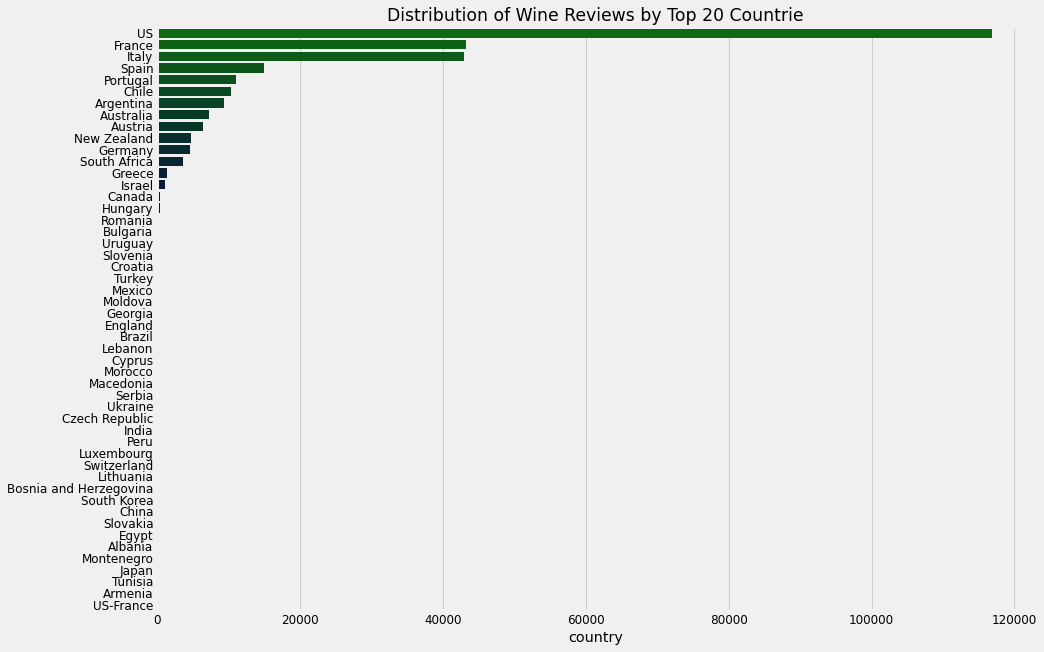

In [14]:
print('Number of country list in data:',wine['country'].nunique())
plt.figure(figsize=(14,10))
cnt = wine['country'].value_counts().to_frame()
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 Countrie')
plt.show()

Оставим только значимые позиции

Number of country list in data: 50


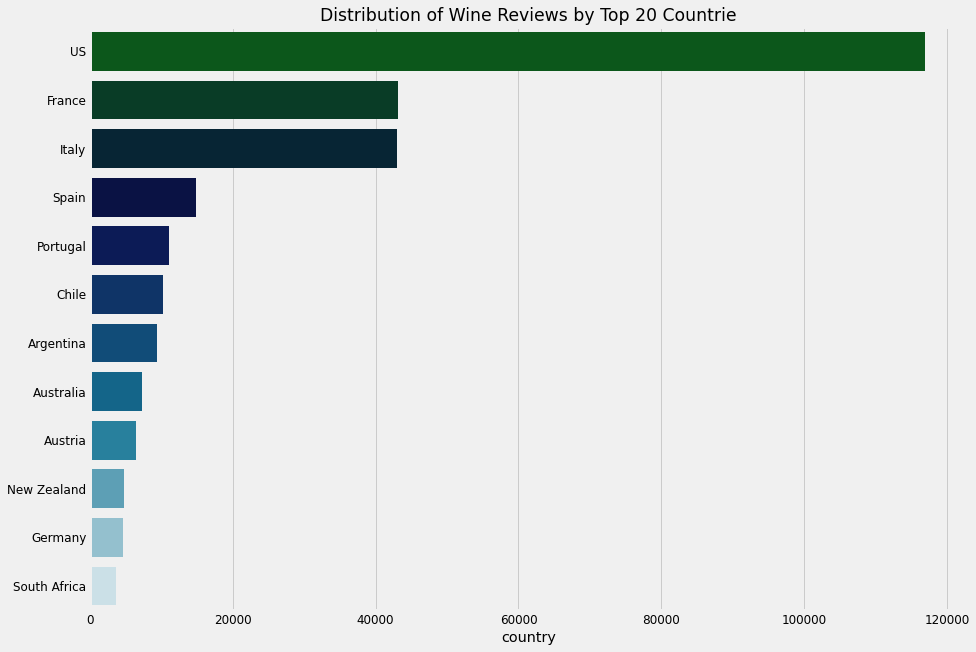

In [15]:
print('Number of country list in data:',wine['country'].nunique())
plt.figure(figsize=(14,10))
cnt = wine['country'].value_counts().to_frame()[:12]
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 Countrie')
plt.show()

In [16]:
cnt_idx = wine['country'].value_counts().to_frame()[:12].index

In [17]:
print('Потери: {0:.3f} %'.format((wine.shape[0] - wine.loc[wine['country'].isin(list(cnt_idx))].shape[0])/wine.shape[0]*100))


Потери: 1.938 %


Потеряли не так много - оставим только эти основные 12 стран и сделаем one_hot_encoding

In [18]:
wine = wine.loc[wine['country'].isin(list(cnt_idx))]

wine = pd.concat([wine.drop('country', axis=1), 
                          pd.get_dummies(wine['country'], prefix='country')], axis=1)
wine.head()

,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,...,country_Austria,country_Chile,country_France,country_Germany,country_Italy,country_New Zealand,country_Portugal,country_South Africa,country_Spain,country_US
0,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,...,0,0,0,0,0,0,0,0,0,1
1,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,...,0,0,0,0,0,0,0,0,1,0
2,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,...,0,0,0,0,0,0,0,0,0,1
3,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,...,0,0,0,0,0,0,0,0,0,1
4,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,...,0,0,1,0,0,0,0,0,0,0


Посмотрим аналогичное распределение по province

In [19]:
wine.shape

(275458, 24)

In [20]:
for col in wine.select_dtypes(include='object'):
    print(f'column: {col}, \tuniques: {len(wine[col].unique())}')

column: description, 	uniques: 166244
column: designation, 	uniques: 45961
column: province, 	uniques: 270
column: region_1, 	uniques: 1321
column: region_2, 	uniques: 19
column: variety, 	uniques: 654
column: winery, 	uniques: 18614
column: taster_name, 	uniques: 18
column: taster_twitter_handle, 	uniques: 15
column: title, 	uniques: 116510


Number of provinces list in data: 270


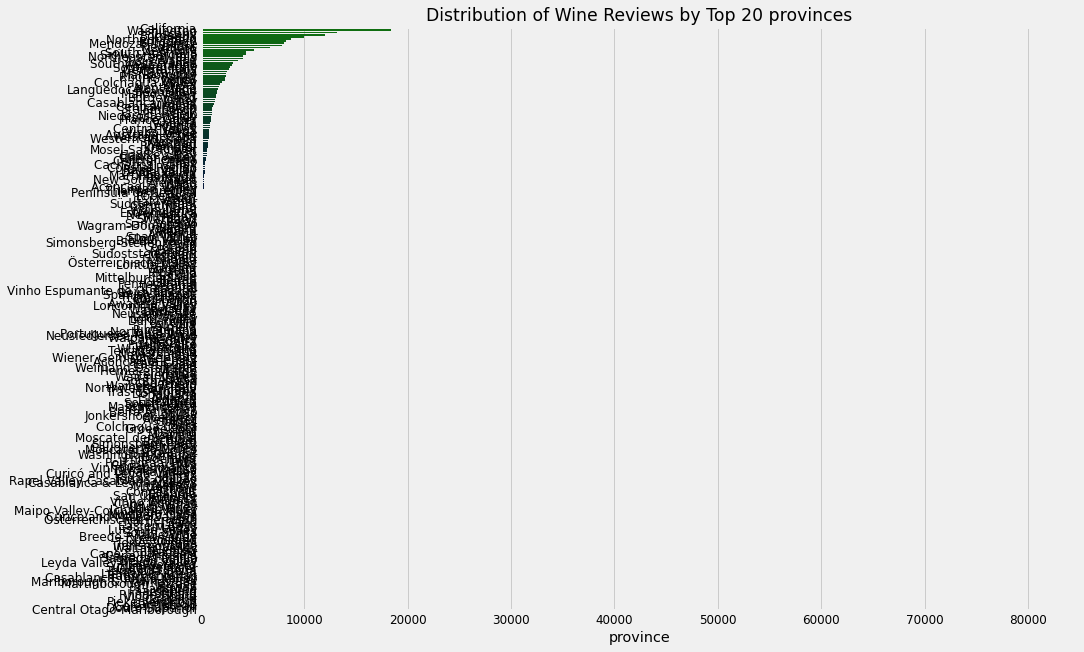

In [21]:
print('Number of provinces list in data:',wine['province'].nunique())
plt.figure(figsize=(14,10))
cnt = wine['province'].value_counts().to_frame()
#plt.xscale('log')
sns.barplot(x= cnt['province'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 provinces')
plt.show()

Оставим только значимые - первые 20 и посмотрим насколько сократится dataset

Number of provinces list in data: 270


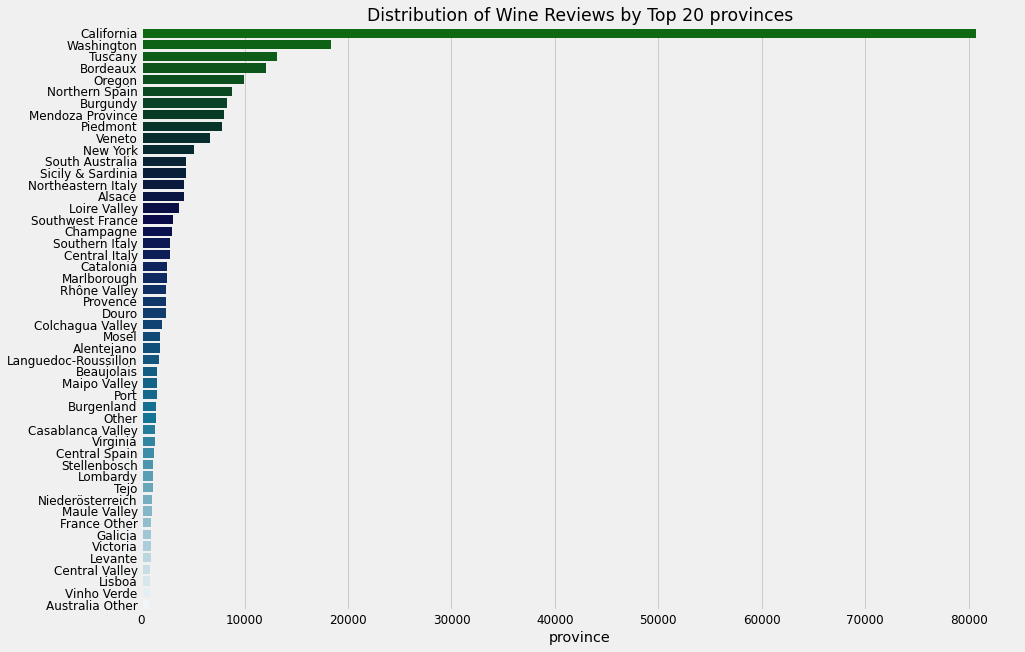

In [22]:
print('Number of provinces list in data:',wine['province'].nunique())
plt.figure(figsize=(14,10))
cnt = wine['province'].value_counts().to_frame()[:50]
#plt.xscale('log')
sns.barplot(x= cnt['province'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 provinces')
plt.show()

In [23]:
pr_idx = wine['province'].value_counts().to_frame()[:50].index
print('Потери: {0:.3f} %'.format((wine.shape[0] - wine.loc[wine['province'].isin(list(pr_idx))].shape[0])/wine.shape[0]*100))


Потери: 7.576 %


Оставляем 50 первых регионов

In [24]:
wine = wine.loc[wine['province'].isin(list(pr_idx))]

wine = pd.concat([wine.drop('province', axis=1), 
                          pd.get_dummies(wine['province'], prefix='province')], axis=1)
wine.shape

(254588, 73)

In [25]:
for col in wine.select_dtypes(include='object'):
    print(f'column: {col}, \tuniques: {len(wine[col].unique())}')

column: description, 	uniques: 153588
column: designation, 	uniques: 41881
column: region_1, 	uniques: 1246
column: region_2, 	uniques: 19
column: variety, 	uniques: 603
column: winery, 	uniques: 17460
column: taster_name, 	uniques: 17
column: taster_twitter_handle, 	uniques: 14
column: title, 	uniques: 108032


# Model

In [26]:
wine.columns

Index(['description', 'designation', 'points', 'price', 'region_1', 'region_2',
       'variety', 'winery', 'taster_name', 'taster_twitter_handle', 'title',
       'country_Argentina', 'country_Australia', 'country_Austria',
       'country_Chile', 'country_France', 'country_Germany', 'country_Italy',
       'country_New Zealand', 'country_Portugal', 'country_South Africa',
       'country_Spain', 'country_US', 'province_Alentejano', 'province_Alsace',
       'province_Australia Other', 'province_Beaujolais', 'province_Bordeaux',
       'province_Burgenland', 'province_Burgundy', 'province_California',
       'province_Casablanca Valley', 'province_Catalonia',
       'province_Central Italy', 'province_Central Spain',
       'province_Central Valley', 'province_Champagne',
       'province_Colchagua Valley', 'province_Douro', 'province_France Other',
       'province_Galicia', 'province_Languedoc-Roussillon', 'province_Levante',
       'province_Lisboa', 'province_Loire Valley', 'provi

Попробуем векторизовать текстовое описание и построить модель на базе случайного леса

In [27]:
# wine_short = wine.head(100000)
wine_short = wine.head(10000)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(wine_short.drop('points', axis=1), 
                                                    wine_short['points'], test_size=0.33, random_state=42)

In [29]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


In [30]:
%%time
classifier = Pipeline([('description_text_selector', FeatureSelector(column='description')), 
                     ('description_text_tfidf', TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', stop_words='english', ngram_range=(1, 1), max_features=10000)), 
                     ('rfor_clf', ensemble.RandomForestRegressor())])

CPU times: user 82 µs, sys: 38 µs, total: 120 µs
Wall time: 124 µs


In [31]:
%%time
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict(X_test)

CPU times: user 1min 21s, sys: 0 ns, total: 1min 21s
Wall time: 1min 21s


In [34]:
# save
with open("models\model_rand_for_reg.dill", "wb") as f:
    dill.dump(classifier, f)

In [33]:
#pip freeze